Качество обученной модели будем смотреть по двум метрикам: MAE, MAPE.

In [1]:
import pandas as pd, numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn import metrics
from tqdm import tqdm
from sklearn.base import clone

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session

Определим функцию для расчета метрики MAPE.

In [2]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

Прочитаем обработанный ранее датасет.

In [3]:
df = pd.read_csv('data_preproc.csv')

In [4]:
df.head(10)

,propertyType,fireplace,city,state,target,sale_status,full_baths,year_built,remodeling,heating,parking,lotsize,price/sqm,average_school_rating,number_of_schools,average_distance_to_school,sqm,sqm^2,sqm_price/sqm,price/sqm^2
0,single-family,no,other,other,310000,for sale,more_than_2,2019.0,no,no info,no_info,541,1711,4.0,3,2.08,181,32761.0,309691.0,2927521.0
1,land,no,other,FL,5000,for sale,no_info,1985.0,no,no info,no_info,931,1884,4.7,3,6.56,173,29929.0,325932.0,3549456.0
2,townhouse,no,other,other,209000,for sale,no_info,1920.0,no,forced air,no_info,63,2508,5.0,3,3.20,83,6889.0,208164.0,6290064.0
3,no info,no,other,TN,68000,active,no_info,1976.0,no,no info,no_info,813,614,2.7,3,1.76,173,29929.0,106222.0,376996.0
4,single-family,no,Houston,TX,311995,no info,more_than_2,2019.0,no,gas,attached garage,191,1744,3.0,3,1.76,179,32041.0,312176.0,3041536.0
5,single-family,no,Houston,TX,168800,no info,more_than_2,1982.0,yes,other,2 spaces,198,743,5.3,3,2.24,228,51984.0,169404.0,552049.0
6,no info,no,other,FL,335000,active,1,2008.0,yes,no info,no_info,493,1636,3.5,4,1.12,205,42025.0,335380.0,2676496.0
7,single-family,yes,other,TX,365000,for sale,more_than_2,2016.0,no,other,attached garage,968,1281,7.0,2,3.04,286,81796.0,366366.0,1640961.0
8,multi-family,no,other,FL,626000,for sale,more_than_2,1954.0,no,forced air,no_info,753,4176,5.0,3,0.64,150,22500.0,626400.0,17438976.0
9,single-family,yes,other,TX,499007,for sale,more_than_2,2019.0,no,electric,attached garage,740,1475,8.3,3,5.12,339,114921.0,500025.0,2175625.0


In [5]:
df.shape

(150214, 20)

In [6]:
df.columns[:]

Index(['propertyType', 'fireplace', 'city', 'state', 'target', 'sale_status',
       'full_baths', 'year_built', 'remodeling', 'heating', 'parking',
       'lotsize', 'price/sqm', 'average_school_rating', 'number_of_schools',
       'average_distance_to_school', 'sqm', 'sqm^2', 'sqm_price/sqm',
       'price/sqm^2'],
      dtype='object')

## Подготовка данных к машинному обучению

### Обработка числовых переменных

In [7]:
num_cols = ['year_built', 'lotsize', 'price/sqm', 'average_school_rating', 'number_of_schools', 'average_distance_to_school', 
            'sqm', 'sqm^2', 'sqm_price/sqm', 'price/sqm^2', 'target']

# Список числовых переменных для датасета data_preproc_6
#num_cols = ['average_school_rating', 'average_distance_to_school', 'sqm', 'target']

Оценим корреляцию числовых переменных.

<AxesSubplot:>

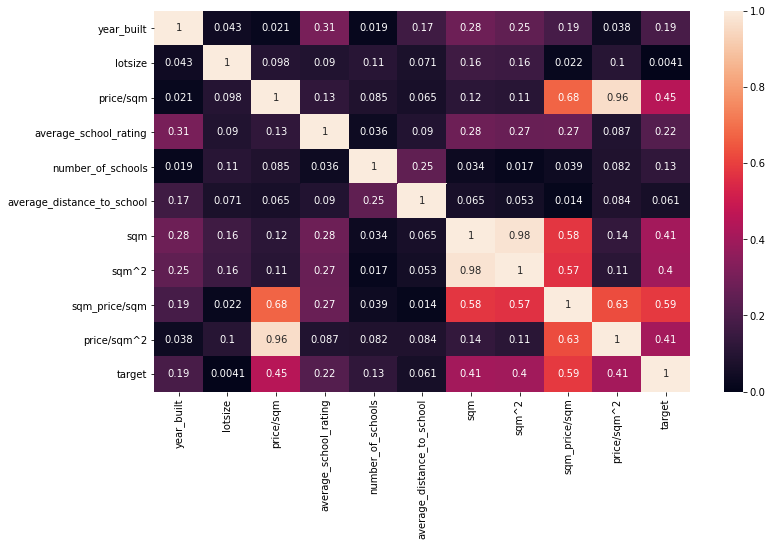

In [8]:
plt.figure(figsize = (12, 7))
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1, annot = True)

Самая высокая корреляция есть у признаков price/sqm и sqm, что логично так как во многом цена дома определяется жилой площадью и ценой за квадратный метр. Прологарифмируем числовые признаки для того, чтобы сгладить распределение.

In [9]:
for col in num_cols:
    df[col] = np.log(df[col] + 1)  

<AxesSubplot:>

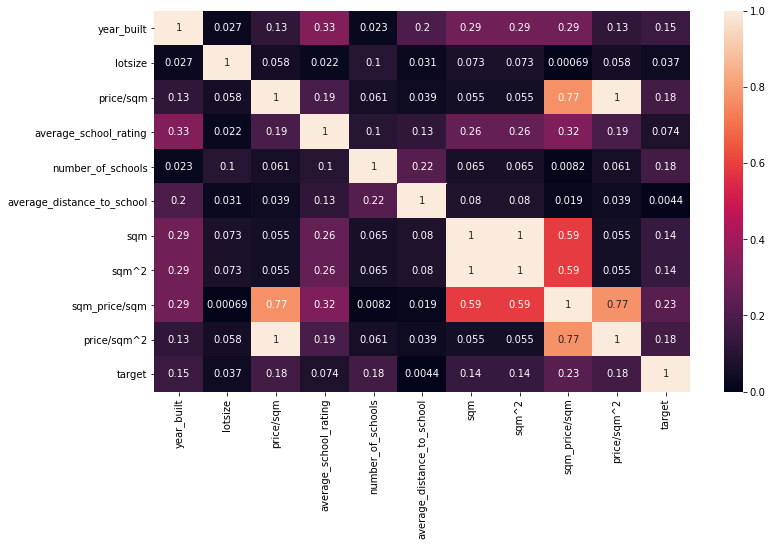

In [10]:
plt.figure(figsize = (12, 7))
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1, annot = True)

После логарифмирования корреляция признаков уменьшилась.

### Обработка бинарных переменных

In [11]:
bin_cols = ['remodeling', 'fireplace']

Применим LabelEncoder ко всему набору бинарных переменных.

In [12]:
label_encoder = LabelEncoder()

for col in bin_cols:
    df[col] = label_encoder.fit_transform(df[col])

### Обработка категориальных переменных

In [13]:
cat_cols = ['sale_status', 'propertyType', 'full_baths', 'heating', 'parking', 'city', 'state']

# Список категориальных переменных для датасета data_preproc_6
#cat_cols = ['house_age', 'plot_size', 'price/sqm', 'sale_status', 'propertyType', 'full_baths', 'heating', 'parking', 'city', 
#            'state']

Осуществим dummy-кодирование категориальных переменных.

In [14]:
X_cat = pd.get_dummies(df[cat_cols])

Объединим dummy-переменные с датафреймом df, предварительно удалив из него исходные категориальные признаки.

In [15]:
df = pd.concat([df[num_cols + bin_cols], X_cat], axis = 1)

In [16]:
df.shape

(150214, 61)

In [17]:
df.columns

Index(['year_built', 'lotsize', 'price/sqm', 'average_school_rating',
       'number_of_schools', 'average_distance_to_school', 'sqm', 'sqm^2',
       'sqm_price/sqm', 'price/sqm^2', 'target', 'remodeling', 'fireplace',
       'sale_status_active', 'sale_status_for sale', 'sale_status_foreclosure',
       'sale_status_new construction', 'sale_status_no info',
       'sale_status_pending', 'sale_status_pre-foreclosure',
       'propertyType_condo', 'propertyType_land', 'propertyType_multi-family',
       'propertyType_no info', 'propertyType_single-family',
       'propertyType_townhouse', 'full_baths_1', 'full_baths_2',
       'full_baths_more_than_2', 'full_baths_no', 'full_baths_no_info',
       'heating_electric', 'heating_forced air', 'heating_gas',
       'heating_heat pump', 'heating_no info', 'heating_other',
       'parking_1 space', 'parking_2 spaces', 'parking_attached garage',
       'parking_detached garage', 'parking_more_than_2_spaces',
       'parking_no_info', 'parking_

In [18]:
X = df.drop('target', axis = 1)
y = df['target']

Разделим данные на обучающую, валидационную и тестовую выборки.

In [19]:
X_train, X_valid_test, y_train, y_valid_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 42)
#X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, test_size = 0.5, random_state = 42)

## Нормализация данных

In [20]:
'''
# MinMax нормализация
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_valid_test = scaler.transform(X_valid_test)
'''

'\n# MinMax нормализация\nscaler = MinMaxScaler()\nX_train = scaler.fit_transform(X_train)\nX_valid_test = scaler.transform(X_valid_test)\n'

In [21]:
# стандартная нормализация
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid_test = scaler.transform(X_valid_test)

In [22]:
y_valid_test = (np.exp(y_valid_test) - 1).values

## Обучение

## GradientBoostingRegressor

In [23]:
gb = GradientBoostingRegressor(n_estimators = 1000, min_samples_split = 2, min_samples_leaf = 1, max_depth = 20, 
                               max_features = 20, learning_rate = 0.01, random_state=42)
gb.fit(X_train, y_train)
y_pred_gbr = np.exp(gb.predict(X_valid_test)) - 1

In [24]:
MAE = metrics.mean_absolute_error(y_valid_test, y_pred_gbr)
MAPE = mape(y_valid_test, y_pred_gbr)

In [25]:
print('MAE = {}'.format(round(MAE)))
print('MAPE = {}'.format(round(MAPE)))

MAE = 20080
MAPE = 94


## XGBoost

In [26]:
'''
xb = xgb.XGBRegressor(objective = 'reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.03, 
                      max_depth = 12, alpha = 1, n_jobs = -1, n_estimators = 1000)
xb.fit(X_train, y_train)
y_pred_xgb = np.exp(xb.predict(X_valid_test)) - 1
'''

"\nxb = xgb.XGBRegressor(objective = 'reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.03, \n                      max_depth = 12, alpha = 1, n_jobs = -1, n_estimators = 1000)\nxb.fit(X_train, y_train)\ny_pred_xgb = np.exp(xb.predict(X_valid_test)) - 1\n"

In [27]:
#MAE = metrics.mean_absolute_error(y_valid_test, y_pred_xgb)
#MAPE = mape(y_valid_test, y_pred_xgb)

In [28]:
#print('MAE = {}'.format(round(MAE)))
#print('MAPE = {}'.format(round(MAPE)))

## Stacking

In [29]:
'''
def compute_meta_feature(reg, X_train, X_test, y_train, cv):
    """
    Computes meta-features using the regressor.
    
    :arg reg: scikit-learn regressor
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_reg = clone(reg)
        folded_reg.fit(X_fold_train, y_fold_train)
        X_meta_train[predict_fold_index] = folded_reg.predict(X_fold_predict)
    
    meta_reg = clone(reg)
    meta_reg.fit(X_train, y_train)
    
    X_meta_test = meta_reg.predict(X_test)
    
    return X_meta_train, X_meta_test
'''

'\ndef compute_meta_feature(reg, X_train, X_test, y_train, cv):\n    """\n    Computes meta-features using the regressor.\n    \n    :arg reg: scikit-learn regressor\n    :args X_train, y_train: training set\n    :arg X_test: testing set\n    :arg cv: cross-validation folding\n    """\n    X_meta_train = np.zeros_like(y_train, dtype=np.float32)\n    for train_fold_index, predict_fold_index in cv.split(X_train):\n        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]\n        y_fold_train = y_train[train_fold_index]\n        \n        folded_reg = clone(reg)\n        folded_reg.fit(X_fold_train, y_fold_train)\n        X_meta_train[predict_fold_index] = folded_reg.predict(X_fold_predict)\n    \n    meta_reg = clone(reg)\n    meta_reg.fit(X_train, y_train)\n    \n    X_meta_test = meta_reg.predict(X_test)\n    \n    return X_meta_train, X_meta_test\n'

In [30]:
'''
def generate_meta_features(regressors, X_train, X_test, y_train, cv):
    """
    Generates metafeatures using a list of classifiers.
    
    :arg regressors: list of scikit-learn regressors
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    features = [
        compute_meta_feature(reg, X_train, X_test, y_train, cv)
        for reg in tqdm(regressors)
    ]
    
    stacked_features_train = np.vstack([
        features_train for features_train, features_test in features
    ]).T

    stacked_features_test = np.vstack([
        features_test for features_train, features_test in features
    ]).T
    
    return stacked_features_train, stacked_features_test
'''

'\ndef generate_meta_features(regressors, X_train, X_test, y_train, cv):\n    """\n    Generates metafeatures using a list of classifiers.\n    \n    :arg regressors: list of scikit-learn regressors\n    :args X_train, y_train: training set\n    :arg X_test: testing set\n    :arg cv: cross-validation folding\n    """\n    features = [\n        compute_meta_feature(reg, X_train, X_test, y_train, cv)\n        for reg in tqdm(regressors)\n    ]\n    \n    stacked_features_train = np.vstack([\n        features_train for features_train, features_test in features\n    ]).T\n\n    stacked_features_test = np.vstack([\n        features_test for features_train, features_test in features\n    ]).T\n    \n    return stacked_features_train, stacked_features_test\n'

In [31]:
'''
cv = KFold(n_splits = 5, shuffle = True)

stacked_features_train, stacked_features_test = generate_meta_features([
    RandomForestRegressor(n_estimators = 1500, min_samples_split = 2, min_samples_leaf = 1, max_depth = 20, bootstrap = True, 
                          max_features = 20, n_jobs = -1, random_state = 42),
    GradientBoostingRegressor(n_estimators = 1000, min_samples_split = 2, min_samples_leaf = 1, max_depth = 20, 
                              max_features = 20, learning_rate = 0.01, random_state = 42),
    xgb.XGBRegressor(objective = 'reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.03, 
                      max_depth = 12, alpha = 1, n_jobs = -1, n_estimators = 1000)
], X_train, X_valid_test, y_train.values, cv)
'''

"\ncv = KFold(n_splits = 5, shuffle = True)\n\nstacked_features_train, stacked_features_test = generate_meta_features([\n    RandomForestRegressor(n_estimators = 1500, min_samples_split = 2, min_samples_leaf = 1, max_depth = 20, bootstrap = True, \n                          max_features = 20, n_jobs = -1, random_state = 42),\n    GradientBoostingRegressor(n_estimators = 1000, min_samples_split = 2, min_samples_leaf = 1, max_depth = 20, \n                              max_features = 20, learning_rate = 0.01, random_state = 42),\n    xgb.XGBRegressor(objective = 'reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.03, \n                      max_depth = 12, alpha = 1, n_jobs = -1, n_estimators = 1000)\n], X_train, X_valid_test, y_train.values, cv)\n"

In [32]:
#st = LinearRegression()
#st.fit(stacked_features_train, y_train)
#y_pred_st = np.exp(st.predict(stacked_features_test)) - 1

In [33]:
#MAE = metrics.mean_absolute_error(y_valid_test, y_pred_st)
#MAPE = mape(y_valid_test, y_pred_st)

In [34]:
#print('MAE = {}'.format(round(MAE)))
#print('MAPE = {}'.format(round(MAPE)))

## Neural Network

In [35]:
#clear_session()

In [36]:
'''
model = Sequential()
model.add(Dense(512, activation = 'relu', input_shape = (X_train.shape[1],)))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'relu'))
'''

"\nmodel = Sequential()\nmodel.add(Dense(512, activation = 'relu', input_shape = (X_train.shape[1],)))\nmodel.add(Dense(512, activation = 'relu'))\nmodel.add(Dense(256, activation = 'relu'))\nmodel.add(Dense(128, activation = 'relu'))\nmodel.add(Dense(64, activation = 'relu'))\nmodel.add(Dense(1, activation = 'relu'))\n"

In [37]:
#model.summary()

In [38]:
'''
model.compile(
    loss = 'mse',
    optimizer = 'adam',
    metrics = [tf.keras.metrics.MeanSquaredError()]
)
'''

"\nmodel.compile(\n    loss = 'mse',\n    optimizer = 'adam',\n    metrics = [tf.keras.metrics.MeanSquaredError()]\n)\n"

In [39]:
'''
model.fit(X_train, 
          y_train, 
          epochs = 10, 
          validation_data = (X_valid_test, y_valid_test)
         )
y_pred_nn = np.exp(model.predict(X_valid_test).flatten()) - 1
'''

'\nmodel.fit(X_train, \n          y_train, \n          epochs = 10, \n          validation_data = (X_valid_test, y_valid_test)\n         )\ny_pred_nn = np.exp(model.predict(X_valid_test).flatten()) - 1\n'

In [40]:
#MAE = metrics.mean_absolute_error(y_valid_test, y_pred_nn)
#MAPE = mape(y_valid_test, y_pred_nn)

In [41]:
#print('MAE = {}'.format(round(MAE)))
#print('MAPE = {}'.format(round(MAPE)))

## Catboost

In [42]:
'''
# Подготовка данных для алгоритма Catboost

df = pd.read_csv('../input/house-price-prediction-eda/data_preproc.csv')

num_cols = ['year_built', 'lotsize', 'price/sqm', 'average_school_rating', 'number_of_schools', 'average_distance_to_school', 
            'sqm', 'sqm^2', 'sqm_price/sqm', 'price/sqm^2', 'target']

# Список числовых переменных для датасета data_preproc_6
#num_cols = ['average_school_rating', 'average_distance_to_school', 'sqm', 'target']

for col in num_cols:
    df[col] = np.log(df[col] + 1)
    
X = df.drop('target', axis = 1)
y = df['target']

X_train, X_valid_test, y_train, y_valid_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 42)
#X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, test_size = 0.5, random_state = 42)

# стандартная нормализация
scaler = StandardScaler()
X_train[list(set(num_cols) - set(['target']))] = scaler.fit_transform(X_train[list(set(num_cols) - set(['target']))])
X_valid_test[list(set(num_cols) - set(['target']))] = scaler.transform(X_valid_test[list(set(num_cols) - set(['target']))])

y_valid_test = (np.exp(y_valid_test) - 1).values
'''

"\n# Подготовка данных для алгоритма Catboost\n\ndf = pd.read_csv('../input/house-price-prediction-eda/data_preproc.csv')\n\nnum_cols = ['year_built', 'lotsize', 'price/sqm', 'average_school_rating', 'number_of_schools', 'average_distance_to_school', \n            'sqm', 'sqm^2', 'sqm_price/sqm', 'price/sqm^2', 'target']\n\n# Список числовых переменных для датасета data_preproc_6\n#num_cols = ['average_school_rating', 'average_distance_to_school', 'sqm', 'target']\n\nfor col in num_cols:\n    df[col] = np.log(df[col] + 1)\n    \nX = df.drop('target', axis = 1)\ny = df['target']\n\nX_train, X_valid_test, y_train, y_valid_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 42)\n#X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, test_size = 0.5, random_state = 42)\n\n# стандартная нормализация\nscaler = StandardScaler()\nX_train[list(set(num_cols) - set(['target']))] = scaler.fit_transform(X_train[list(set(num_cols) - set(['target'])

In [43]:
'''
cb = CatBoostRegressor(iterations = 5000,
                       one_hot_max_size = 2,
                       random_seed = 42)
cb.fit(X_train, y_train, 
       cat_features = cat_cols + bin_cols,
       eval_set = (X_valid_test, y_valid_test), 
       logging_level = 'Silent',
       plot = False)
y_pred_cb = np.exp(cb.predict(X_valid_test)) - 1
'''

"\ncb = CatBoostRegressor(iterations = 5000,\n                       one_hot_max_size = 2,\n                       random_seed = 42)\ncb.fit(X_train, y_train, \n       cat_features = cat_cols + bin_cols,\n       eval_set = (X_valid_test, y_valid_test), \n       logging_level = 'Silent',\n       plot = False)\ny_pred_cb = np.exp(cb.predict(X_valid_test)) - 1\n"

In [44]:
#MAE = metrics.mean_absolute_error(y_valid_test, y_pred_cb)
#MAPE = mape(y_valid_test, y_pred_cb)

In [45]:
#print('MAE = {}'.format(round(MAE)))
#print('MAPE = {}'.format(round(MAPE)))

Было обучено 3 бустинговых модели, 1 нейронная сеть, сделан стекинг. Все алгоритмы показали неудовлетворительное качество. Далее приводятся оценки качества на обученных моделях.


**GradientBoostingRegressor**

GradientBoostingRegressor(n_estimators = 1000, min_samples_split = 2, min_samples_leaf = 1, max_depth = 20, max_features = 20, learning_rate = 0.01, random_state=42)

MAE = 20080 $,     MAPE = 94 %

**CatBoostRegressor**

CatBoostRegressor(iterations = 5000, one_hot_max_size = 2, random_seed = 42)

MAE = 30085 $,     MAPE = 88 %

**XGBRegressor**

XGBRegressor(objective = 'reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.03, 
                           max_depth = 12, alpha = 1, n_jobs = -1, n_estimators = 1000)

MAE = 24675 $,     MAPE = 87 %

**Stacking**

Stacking (RandomForestRegressor, GradientBoostingRegressor, XGBRegressor)

MAE = 26963 $,     MAPE = 99 %

**Neural Network**

MAE = 43189 $,     MAPE = 93 %





Таким образом лучшее качество показал алгоритм **GradientBoostingRegressor MAE = 20080 $ и MAPE = 94 %**.
